# Exercícios - Aula 3

Para resolver esses exercícios primeiro vai ser feita a implementação do Classificador Bayesiano baseada no notebook do professor (com algumas pequenas alterações).

## Importação das bibliotecas que vão ser usadas durante toda a resolução

In [18]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from scipy.stats import multivariate_normal
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

random.seed(2)

plt.style.use("ggplot")

## Implementação do classificador bayesiano parametrico

In [21]:
# Lê os dados de um arquivo .csv

data = pd.read_csv('data/vertebralcolumn-3C.csv', header = (0))
data = data.dropna(axis = 'rows') # Remove linhas que contenham NaN (not a number)

data.head(10)

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Hernia
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Hernia
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Hernia
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Hernia
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Hernia
5,40.250200,13.921907,25.124950,26.328293,130.327871,2.230652,Hernia
6,53.432928,15.864336,37.165934,37.568592,120.567523,5.988551,Hernia
7,45.366754,10.755611,29.038349,34.611142,117.270067,-10.675871,Hernia
8,43.790190,13.533753,42.690814,30.256437,125.002893,13.289018,Hernia
9,36.686353,5.010884,41.948751,31.675469,84.241415,0.664437,Hernia


In [22]:
# Vamos armazenar os nomes das classes possíveis do dataset em uma numpy array
classes = np.array(pd.unique(data[data.columns[-1]]), dtype = str)

classes

array(['Hernia', 'Spondylolisthesis', 'Normal'], dtype='<U17')

In [23]:
print("O dataset contém {} atributos e {} observações.".format(data.shape[1], data.shape[0]))
print("Atributos do dataset:")

list(data.columns)

O dataset contém 7 atributos e 310 observações.
Atributos do dataset:


['pelvic_incidence',
 'pelvic_tilt',
 'lumbar_lordosis_angle',
 'sacral_slope',
 'pelvic_radius',
 'degree_spondylolisthesis',
 'class']

In [24]:
# Converte os dados em uma array do numpy
data_np = data.to_numpy()

data_np

array([[63.027817000000006, 22.552585999999998, 39.609117, ...,
        98.672917, -0.2544, 'Hernia'],
       [39.056951, 10.060991, 25.015378, ..., 114.405425, 4.564259,
        'Hernia'],
       [68.832021, 22.218482, 50.092194, ..., 105.98513500000001,
        -3.5303169999999997, 'Hernia'],
       ...,
       [61.446597, 22.694968, 46.170347, ..., 125.670725, -2.70788,
        'Normal'],
       [45.252792, 8.693157000000001, 41.583126, ..., 118.545842,
        0.21475, 'Normal'],
       [33.841640999999996, 5.073991, 36.641233, ..., 123.94524399999999,
        -0.199249, 'Normal']], dtype=object)

In [25]:
# Vamos guardar as nossas clsses em y (que vamos tentar predizer)
y = data_np[:,-1]
# E as amostras com seus atributos em X
X = data_np[:,0:data.shape[1]-1]

print(y[0], X[0])

data.head(1)

Hernia [63.027817000000006 22.552585999999998 39.609117 40.475232 98.672917
 -0.2544]


,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.2544,Hernia


In [26]:
# Normaliza os dados para facilitar os cálculos

scaler = StandardScaler().fit(X)
X_scale = scaler.transform(X)

print("Média dos atributos (normalizados):\n{}\b\nDesvio padrão dos atributos(normalizados):\n{}".format(np.mean(X_scale, axis = 0), np.std(X_scale, axis = 0)))

Média dos atributos (normalizados):
[ 1.14603667e-16 -4.58414668e-17 -3.66731735e-16 -5.73018335e-17
  3.55271368e-16 -6.87622002e-17
Desvio padrão dos atributos(normalizados):
[1. 1. 1. 1. 1. 1.]


In [27]:
# Para treinar o classificador vamos separar o dataset em training set e test set (80% train set e 20% test set)

x_train, x_test, y_train, y_test = train_test_split(X_scale, y, train_size = 0.8, random_state = 42)

x_train.shape, x_test.shape

((248, 6), (62, 6))

In [28]:
# Matriz que vai guardar as probabilidades de P(Ci | X)
P = pd.DataFrame(data = np.zeros((x_test.shape[0], len(classes))), columns = classes)
# Matriz que vai guardar a probabildiade de P(Ci)
Pc = np.zeros(len(classes))

for i in range(len(classes)):
    # Vamos obter os elementos que pertencem a classe Ci no conjunto de treino
    elementos_da_classe = np.where(y_train == classes[i])[0]
    # Calculando a probabilidade de P(Ci)
    Pc[i] = len(elementos_da_classe) / len(y_train)

    print("P(Classe {}): {:.4f}".format(classes[i], Pc[i]))

    # Agora pegamos apenas os elementos que pertencem a classe Ci do x_train
    Z = x_train[elementos_da_classe]
    # Calculando o valor da média amostral
    mu = np.mean(Z, axis = 0)
    # Calculando o valor do desvio padrão amostral
    sigma = np.std(Z, axis = 0)
    # Calculando a matriz de covariância de cada atributo
    cv = np.cov(Z.T)

    # Agora que temos P(Ci | X) podemos calcular P(X | Ci)
    pjj = multivariate_normal.pdf(x_test, mean = mu, cov = cv, allow_singular = True)

    # E colocamos a probabilidade de P(Xj | Ci) no nosso dataframe
    P[classes[i]] = pjj * Pc[i]

P(Classe Hernia): 0.1935
P(Classe Spondylolisthesis): 0.4758
P(Classe Normal): 0.3306


In [29]:
P

,Hernia,Spondylolisthesis,Normal
0,5.609535e-03,0.000115,2.774100e-02
1,5.798763e-08,0.000023,1.639501e-11
2,9.222092e-02,0.000597,4.794886e-02
3,1.616134e-26,0.000532,1.393848e-18
4,3.532779e-02,0.000132,2.994091e-03
...,...,...,...
57,7.608751e-12,0.002016,1.793824e-07
58,1.818440e-16,0.000163,6.458973e-12
59,1.916809e-02,0.000109,1.108650e-02
60,3.715309e-09,0.000085,1.829142e-06


In [30]:
# Agora podemos predizer sobre os nosso dados
y_pred = []

for i in np.arange(0, x_test.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred.append(classes[c])
y_pred = np.array(y_pred, dtype=str)

y_pred

array(['Normal', 'Spondylolisthesis', 'Hernia', 'Spondylolisthesis',
       'Hernia', 'Spondylolisthesis', 'Spondylolisthesis',
       'Spondylolisthesis', 'Hernia', 'Hernia', 'Spondylolisthesis',
       'Spondylolisthesis', 'Normal', 'Normal', 'Normal', 'Hernia',
       'Normal', 'Spondylolisthesis', 'Spondylolisthesis',
       'Spondylolisthesis', 'Spondylolisthesis', 'Spondylolisthesis',
       'Spondylolisthesis', 'Spondylolisthesis', 'Spondylolisthesis',
       'Spondylolisthesis', 'Spondylolisthesis', 'Normal', 'Normal',
       'Normal', 'Spondylolisthesis', 'Hernia', 'Spondylolisthesis',
       'Normal', 'Spondylolisthesis', 'Spondylolisthesis', 'Hernia',
       'Normal', 'Spondylolisthesis', 'Spondylolisthesis', 'Normal',
       'Hernia', 'Spondylolisthesis', 'Normal', 'Normal',
       'Spondylolisthesis', 'Normal', 'Normal', 'Hernia',
       'Spondylolisthesis', 'Spondylolisthesis', 'Normal',
       'Spondylolisthesis', 'Spondylolisthesis', 'Spondylolisthesis',
       'Spondyl

In [31]:
score = accuracy_score(y_pred, y_test)

print('Accuracy:', score)

Accuracy: 0.7903225806451613


## Implementaçaõ do clasificador Bayesiano não parâmetrico

Para fazer esse classificador vamos utilizar os dados já normalizados e uma boa parte do código que segue a mesma ideia para essa nova classificação.

In [32]:
# Matriz que vai guardar as probabilidades de P(Ci | X)
P = pd.DataFrame(data = np.zeros((x_test.shape[0], len(classes))), columns = classes)
# Matriz que vai guardar a probabildiade de P(Ci)
Pc = np.zeros(len(classes))

for i in range(len(classes)):
    # Vamos obter os elementos que pertencem a classe Ci no conjunto de treino
    elementos_da_classe = np.where(y_train == classes[i])[0]
    # Calculando a probabilidade de P(Ci)
    Pc[i] = len(elementos_da_classe) / len(y_train)

    print("P(Classe {}): {:.4f}".format(classes[i], Pc[i]))

    # Agora pegamos apenas os elementos que pertencem a classe Ci do x_train
    Z = x_train[elementos_da_classe]
    
    # Agora aplicamos a função kernel (gaussiana) com h = 2
    kde = KernelDensity(kernel = "gaussian", bandwidth = 2).fit(Z)

    pjj = np.exp(kde.score_samples(x_test))

    # E colocamos a probabilidade de P(Xj | Ci) no nosso dataframe
    P[classes[i]] = pjj * Pc[i]

P(Classe Hernia): 0.1935
P(Classe Spondylolisthesis): 0.4758
P(Classe Normal): 0.3306


In [33]:
P

,Hernia,Spondylolisthesis,Normal
0,8.301389e-06,0.000006,0.000015
1,3.976315e-06,0.000005,0.000005
2,9.716268e-06,0.000009,0.000015
3,1.507235e-06,0.000009,0.000003
4,8.535326e-06,0.000007,0.000012
...,...,...,...
57,3.145803e-06,0.000016,0.000008
58,1.234321e-06,0.000011,0.000004
59,8.403772e-06,0.000005,0.000013
60,8.528218e-07,0.000009,0.000002


In [34]:
# Agora podemos predizer sobre os nosso dados
y_pred = []

for i in np.arange(0, x_test.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred.append(classes[c])
y_pred = np.array(y_pred, dtype=str)

y_pred

array(['Normal', 'Normal', 'Normal', 'Spondylolisthesis', 'Normal',
       'Spondylolisthesis', 'Spondylolisthesis', 'Spondylolisthesis',
       'Spondylolisthesis', 'Normal', 'Spondylolisthesis',
       'Spondylolisthesis', 'Normal', 'Normal', 'Spondylolisthesis',
       'Normal', 'Normal', 'Spondylolisthesis', 'Normal',
       'Spondylolisthesis', 'Normal', 'Spondylolisthesis',
       'Spondylolisthesis', 'Spondylolisthesis', 'Spondylolisthesis',
       'Spondylolisthesis', 'Spondylolisthesis', 'Normal', 'Normal',
       'Normal', 'Spondylolisthesis', 'Spondylolisthesis',
       'Spondylolisthesis', 'Spondylolisthesis', 'Spondylolisthesis',
       'Spondylolisthesis', 'Normal', 'Normal', 'Spondylolisthesis',
       'Spondylolisthesis', 'Normal', 'Normal', 'Spondylolisthesis',
       'Normal', 'Normal', 'Spondylolisthesis', 'Normal', 'Normal',
       'Normal', 'Spondylolisthesis', 'Spondylolisthesis', 'Normal',
       'Spondylolisthesis', 'Spondylolisthesis', 'Spondylolisthesis',
    

In [35]:
score = accuracy_score(y_pred, y_test)

print('Accuracy:', score)

Accuracy: 0.6935483870967742


Conseguimos uma acurácia menor (mas ainda seria necessário ver outras métricas para ter uma analíse aprofundada), porém é esperado que possa acontecer, dado que precisamos fazer uma estimação para o tipo de distribuição e para o h (já que tanto o caso parâmetrico como não parâmetrico tentamos estimar a curva responsável pelos dados).

## Exercícios

### 1 - Considere outras distribuições na classificação dos dados, além da Normal.

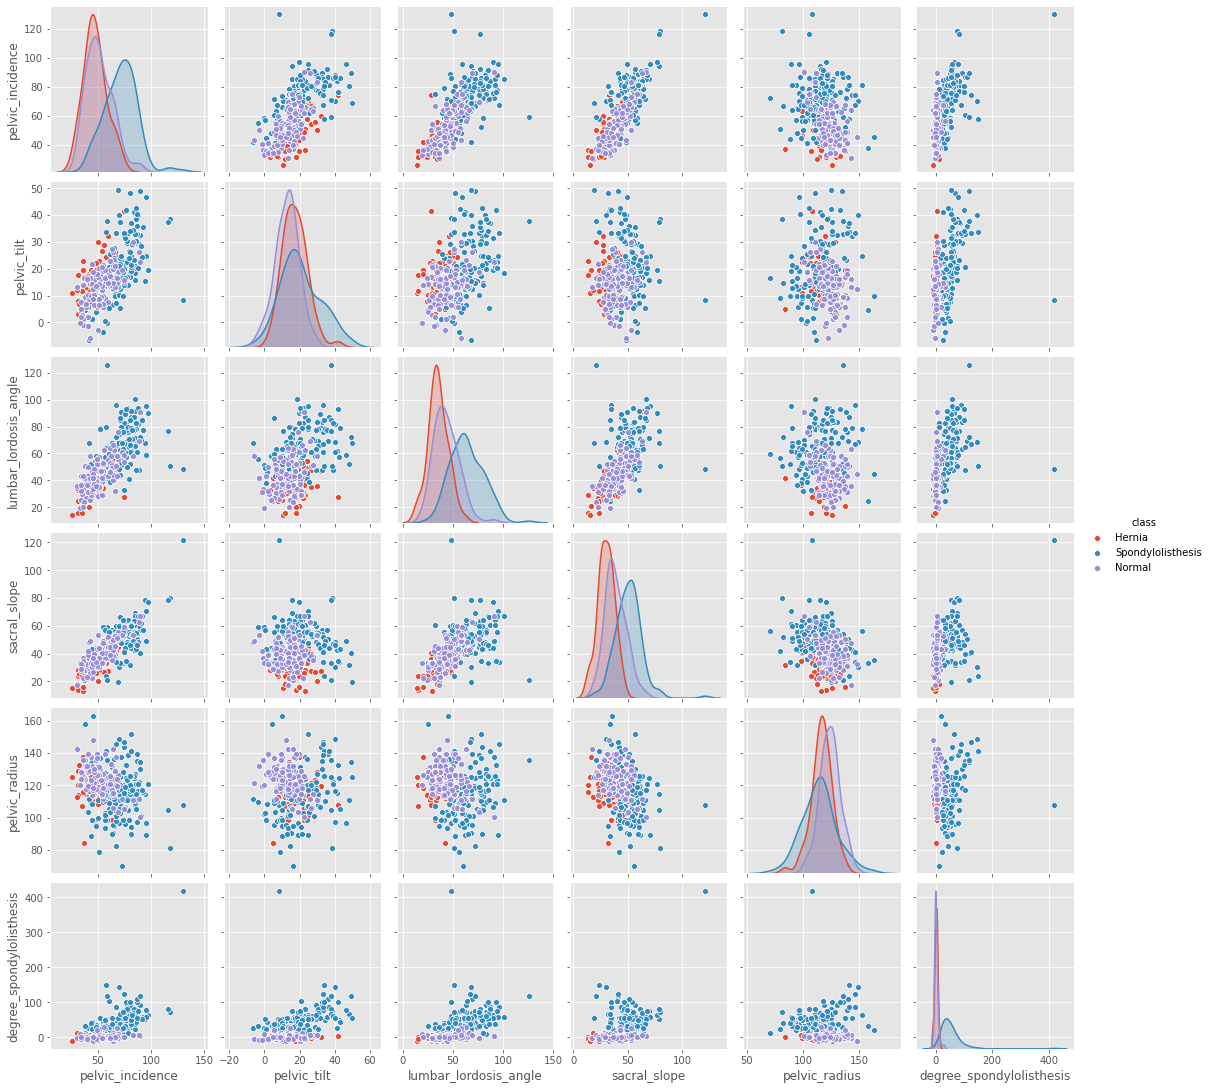

In [36]:
sns.pairplot(data, hue = "class")
plt.show()

In [ ]:
# TO-DO

### 2 - Verifique como o parâmetro $h$ influencia na classificação.

Para fazer esse passo vamos verificar a evolução da acurácia com h variando de $[1, 10]$.

In [51]:
h_interval = np.arange(1, 10 + 1, 1)

h_interval

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [52]:
h_score = []

for h in h_interval:
    # Matriz que vai guardar as probabilidades de P(Ci | X)
    P = pd.DataFrame(data = np.zeros((x_test.shape[0], len(classes))), columns = classes)
    # Matriz que vai guardar a probabildiade de P(Ci)
    Pc = np.zeros(len(classes))

    for i in range(len(classes)):
        # Vamos obter os elementos que pertencem a classe Ci no conjunto de treino
        elementos_da_classe = np.where(y_train == classes[i])[0]
        # Calculando a probabilidade de P(Ci)
        Pc[i] = len(elementos_da_classe) / len(y_train)

        # Agora pegamos apenas os elementos que pertencem a classe Ci do x_train
        Z = x_train[elementos_da_classe]
        
        # Agora aplicamos a função kernel (gaussiana) com h = 2
        kde = KernelDensity(kernel = "gaussian", bandwidth = h).fit(Z)

        pjj = np.exp(kde.score_samples(x_test))

        # E colocamos a probabilidade de P(Xj | Ci) no nosso dataframe
        P[classes[i]] = pjj * Pc[i]

        # Agora podemos predizer sobre os nosso dados
    y_pred = []

    for i in np.arange(0, x_test.shape[0]):
        c = np.argmax(np.array(P.iloc[[i]]))
        y_pred.append(classes[c])
    y_pred = np.array(y_pred, dtype=str)

    score = accuracy_score(y_pred, y_test)
    
    h_score.append(score)

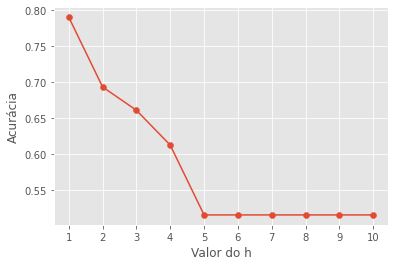

In [63]:
# Mostra a acurácia para cada h

plt.plot(h_interval, h_score)
plt.scatter(h_interval, h_score)

plt.xlabel('Valor do h')
plt.ylabel('Acurácia')
plt.xticks(list(h_interval))

plt.show()

Note que quando $h = 1$ o valor da acurácia é muito alto, porém para esse valor de $h$ a função kernel apenas está "fitando" os dados do conjunto de treino, não vai generalizar para dados novos e bem diferentes do conjunto de treino.